In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, \
  GlobalAveragePooling1D, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
# https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones
# https://www.kaggle.com/erenaktas/human-activity-recognition
!wget -nc https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip

--2021-06-18 06:42:18--  https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/zip]
Saving to: ‘UCI-HAR.zip’

UCI-HAR.zip         100%[===================>]  58.17M  6.08MB/s    in 19s     

2021-06-18 06:42:37 (3.03 MB/s) - ‘UCI-HAR.zip’ saved [60999314/60999314]



In [ ]:
!unzip -nq UCI-HAR.zip

In [ ]:
# Obtain these by inspecting the files
T = 128
Ntrain = 7352
Ntest = 2947
D = 9 # since there are 9 files
K = 6 # number of classes (1-6)

In [ ]:
def load_data():
  # Returns:
  # Xtrain (Ntrain x T x D), Ytrain (Ntrain)
  # Xtest (Ntest x T x D), Ytest (Ntest)

  Xtrain = np.zeros((Ntrain, T, D))
  Xtest = np.zeros((Ntest, T, D))

  # train data
  ts_filenames = [
    'body_acc_x_train.txt', 'body_gyro_x_train.txt', 'total_acc_x_train.txt',
    'body_acc_y_train.txt', 'body_gyro_y_train.txt', 'total_acc_y_train.txt',
    'body_acc_z_train.txt', 'body_gyro_z_train.txt', 'total_acc_z_train.txt',
  ]

  ts_file_prefix = 'UCI HAR Dataset/train/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(
        f'{ts_file_prefix}Inertial Signals/{fn}',
        header=None,
        delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtrain[:, :, d] = x
  
  # train labels
  Ytrain = pd.read_csv(
      f'{ts_file_prefix}y_train.txt', header=None).to_numpy() - 1
  Ytrain = Ytrain.flatten()

  # test data
  ts_filenames = [
    'body_acc_x_test.txt', 'body_gyro_x_test.txt', 'total_acc_x_test.txt',
    'body_acc_y_test.txt', 'body_gyro_y_test.txt', 'total_acc_y_test.txt',
    'body_acc_z_test.txt', 'body_gyro_z_test.txt', 'total_acc_z_test.txt',
  ]

  ts_file_prefix = 'UCI HAR Dataset/test/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(
        f'{ts_file_prefix}Inertial Signals/{fn}',
        header=None,
        delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtest[:, :, d] = x
  
  # test labels
  Ytest = pd.read_csv(
      f'{ts_file_prefix}y_test.txt', header=None).to_numpy() - 1
  Ytest = Ytest.flatten()

  return Xtrain, Ytrain, Xtest, Ytest

In [ ]:
Xtrain, Ytrain, Xtest, Ytest = load_data()

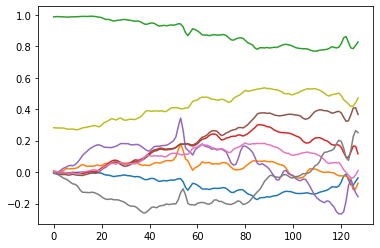

In [ ]:
# plot all D=9 time series of length T=128
plt.plot(Xtrain[7000, :, :]);

In [ ]:
# CNN
i = Input(shape=(T, D))
x = Conv1D(32, 5, activation='relu')(i)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)
model = Model(i, x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 9)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 124, 32)           1472      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 41, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 39, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 17, 128)           24704     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0     

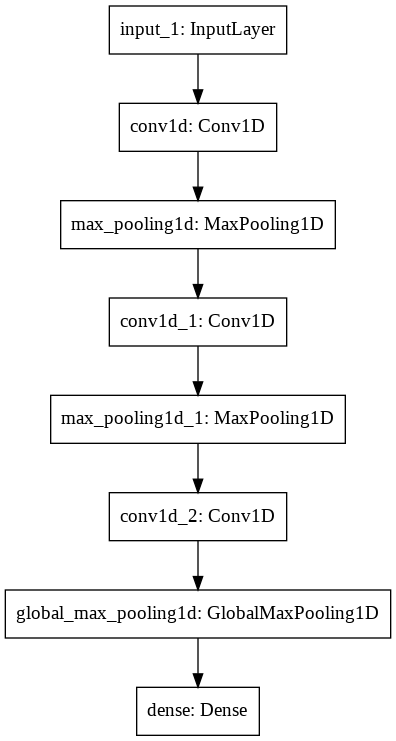

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', save_best_only=True)

In [ ]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy'],
)

In [ ]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=15,
  callbacks=[check_point],
  validation_data=(Xtest, Ytest),
)

Epoch 1/15
230/230 [==============================] - 33s 6ms/step - loss: 0.4047 - accuracy: 0.8672 - val_loss: 0.2423 - val_accuracy: 0.8982
Epoch 2/15
230/230 [==============================] - 1s 4ms/step - loss: 0.1198 - accuracy: 0.9528 - val_loss: 0.2601 - val_accuracy: 0.9135
Epoch 3/15
230/230 [==============================] - 1s 4ms/step - loss: 0.1068 - accuracy: 0.9555 - val_loss: 0.2198 - val_accuracy: 0.9145
Epoch 4/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0967 - accuracy: 0.9595 - val_loss: 0.2092 - val_accuracy: 0.9223
Epoch 5/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0907 - accuracy: 0.9629 - val_loss: 0.2839 - val_accuracy: 0.9121
Epoch 6/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0838 - accuracy: 0.9627 - val_loss: 0.2294 - val_accuracy: 0.9145
Epoch 7/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0787 - accuracy: 0.9663 - val_loss: 0.2616 - val_accuracy: 0.9125
Epoch

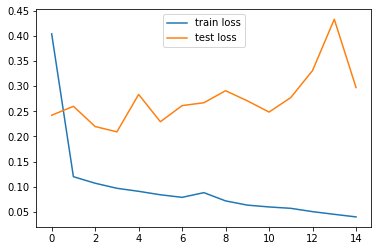

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

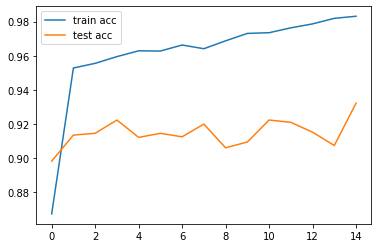

In [ ]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [ ]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [ ]:
# make predictions
Ptest = best_model.predict(Xtest)

In [ ]:
# evaluate
np.mean(np.argmax(Ptest, axis=1) == Ytest)

0.9321343739395996

In [ ]:
from sklearn.preprocessing import StandardScaler

def load_features():
  # Returns:
  # X_train (Ntrain x D)
  # X_test (Ntest x D)

  # train data
  df = pd.read_csv(
        'UCI HAR Dataset/train/X_train.txt',
        header=None,
        delim_whitespace=True)
  
  feat_train = df.to_numpy()

  # test data
  df = pd.read_csv(
        'UCI HAR Dataset/test/X_test.txt',
        header=None,
        delim_whitespace=True)
  
  feat_test = df.to_numpy()

  scaler = StandardScaler()
  feat_train = scaler.fit_transform(feat_train)
  feat_test = scaler.transform(feat_test)

  return feat_train, feat_test

In [ ]:
feat_train, feat_test = load_features()

In [ ]:
D_feat = feat_train.shape[1]

In [ ]:
# Combined Model

# CNN
i = Input(shape=(T, D))
x = Conv1D(32, 5, activation='relu')(i)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

# ANN
i2 = Input(shape=(D_feat,))
x2 = Dense(64, activation='relu')(i2)

x = Concatenate()([x, x2])
x = Dense(K)(x)
model = Model([i, i2], x)

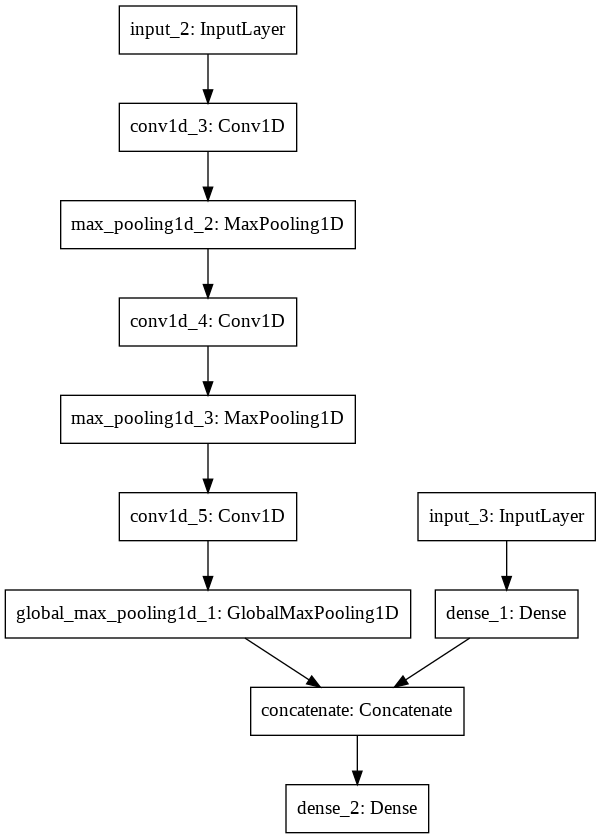

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
check_point3 = ModelCheckpoint(
    'best_model_combined.h5', monitor='val_accuracy', save_best_only=True)

In [ ]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy'],
)

In [ ]:
r = model.fit(
  [Xtrain, feat_train],
  Ytrain,
  epochs=15,
  callbacks=[check_point3],
  validation_data=([Xtest, feat_test], Ytest),
)

Epoch 1/15
230/230 [==============================] - 2s 6ms/step - loss: 0.2222 - accuracy: 0.9185 - val_loss: 0.1540 - val_accuracy: 0.9396
Epoch 2/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0734 - accuracy: 0.9705 - val_loss: 0.1545 - val_accuracy: 0.9491
Epoch 3/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0494 - accuracy: 0.9801 - val_loss: 0.1184 - val_accuracy: 0.9572
Epoch 4/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0426 - accuracy: 0.9839 - val_loss: 0.1305 - val_accuracy: 0.9579
Epoch 5/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0367 - accuracy: 0.9880 - val_loss: 0.1251 - val_accuracy: 0.9593
Epoch 6/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0336 - accuracy: 0.9879 - val_loss: 0.1260 - val_accuracy: 0.9593
Epoch 7/15
230/230 [==============================] - 1s 4ms/step - loss: 0.0301 - accuracy: 0.9883 - val_loss: 0.1757 - val_accuracy: 0.9471
Epoch 

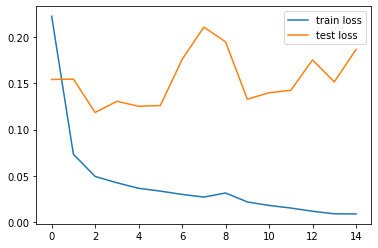

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

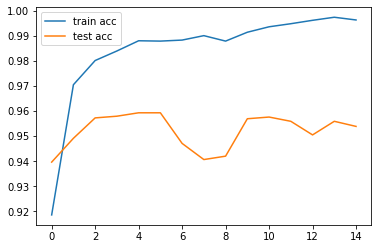

In [ ]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [ ]:
# load best model
best_model = tf.keras.models.load_model('best_model_combined.h5')

In [ ]:
# make predictions
Ptest = best_model.predict([Xtest, feat_test])

In [ ]:
# evaluate
np.mean(np.argmax(Ptest, axis=1) == Ytest)

0.9592806243637597